# HCP Dataset - Gambling Experiment

## Load HCP parcellated task data
### (version with Behavioural Data)

The HCP dataset comprises task-based fMRI from a large sample of human subjects. The NMA-curated dataset includes time series data that has been preprocessed and spatially-downsampled by aggregating within 360 regions of interest.

In order to use this dataset, please electronically sign the HCP data use terms at [ConnectomeDB](https://db.humanconnectome.org). Instructions for this are on pp. 24-25 of the [HCP Reference Manual](https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf).

In this notebook, NMA provides code for downloading the data and doing some basic visualisation and processing.

In [1]:
# # @title Install dependencies
# %pip install nilearn --quiet

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#@title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [4]:
# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 100

# The data have already been aggregated into ROIs from the Glasser parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in seconds

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated twice in each subject
RUNS   = ['LR','RL']
N_RUNS = 2

# There are 7 tasks. Each has a number of 'conditions'
# TIP: look inside the data folders for more fine-graned conditions

EXPERIMENTS = {
    'MOTOR'      : {'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']},
    'EMOTION'    : {'cond':['fear','neut']},
    'GAMBLING'   : {'cond':['loss','win']},
    'LANGUAGE'   : {'cond':['math','story']},
    'RELATIONAL' : {'cond':['match','relation']},
    'SOCIAL'     : {'cond':['ment','rnd']}
}

> For a detailed description of the tasks have a look pages 45-54 of the [HCP reference manual](https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf).

## Demographic Data Importer

In [ ]:
# from collections import Counter

# def get_subject_data(subject_id, column_number):
#     file_name = "demo_data.csv"
#     url = "https://raw.githubusercontent.com/drarkadeep/assets/main/demo_data.csv"

#     try:
#         if not os.path.exists(file_name):
#             response = requests.get(url)
#             response.raise_for_status()
#             with open(file_name, 'wb') as f:
#                 f.write(response.content)

#         df = pd.read_csv(file_name)

#         if column_number >= len(df.columns):
#             raise ValueError(f"Column number {column_number} is out of range.")

#         row = df[df.iloc[:, 0] == int(subject_id)]

#         if row.empty:
#             print(f"No data found for subject ID: {subject_id}")
#             return None

#         return row.iloc[0, column_number]

#     except requests.RequestException as e:
#         print(f"Error downloading the CSV: {str(e)}")
#         return None
#     except pd.errors.EmptyDataError:
#         print("Error: The CSV file is empty.")
#         return None
#     except Exception as e:
#         print(f"An error occurred: {str(e)}")
#         return None

# def get_subject_gender(subject_id):
#     gender = get_subject_data(subject_id, column_number=3)
#     return gender

# def get_subject_age(subject_id):
#     gender = get_subject_data(subject_id, column_number=4)
#     return gender

# def basic_demographic_analysis(data):
#   element_counts = Counter(data)
#   return element_counts

# print(get_subject_gender(subjects[1]))
# print(get_subject_age(subjects[1]))

# gender_data = []
# age_data = []
# for i in range(len(subjects)):
#     gender_data.append(get_subject_gender(subjects[i]))
# for i in range(len(subjects)):
#     age_data.append(get_subject_age(subjects[i]))

# gender_counts = basic_demographic_analysis(gender_data, 0)
# print(gender_counts)
# age_counts = basic_demographic_analysis(age_data, 1)
# print(age_counts)

## Downloading data

The task data are shared in different files, but they will unpack into the same directory structure.


In [5]:
# # @title Download data file
# import os, requests

# fname = "hcp_task.tgz"
# url = "https://osf.io/2y3fw/download"

# if not os.path.isfile(fname):
#   try:
#     r = requests.get(url)
#   except requests.ConnectionError:
#     print("!!! Failed to download data !!!")
#   else:
#     if r.status_code != requests.codes.ok:
#       print("!!! Failed to download data !!!")
#     else:
#       with open(fname, "wb") as fid:
#         fid.write(r.content)

In [6]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp_task"

# # importing the "tarfile" module
# import tarfile

# if not os.path.exists(HCP_DIR):
#     # If the folder does not exist, create it and extract the tar file
#     os.makedirs(HCP_DIR)
#     # open file
#     with tarfile.open(fname) as tfile:
#       # extracting file
#       tfile.extractall('.')

subjects = np.loadtxt(os.path.join(HCP_DIR, 'subjects_list.txt'), dtype='str')

## Understanding the folder organisation

The data folder has the following organisation:

- hcp
  - regions.npy (information on the brain parcellation)
  - subjects_list.txt (list of subject IDs)
  - subjects (main data folder)
    - [subjectID] (subject-specific subfolder)
      - EXPERIMENT (one folder per experiment)
        - RUN (one folder per run)
          - data.npy (the parcellated time series data)
          - EVs (EVs folder)
            - [ev1.txt] (one file per condition)
            - [ev2.txt]
            - Stats.txt (behavioural data [where available] - averaged per run)
            - Sync.txt (ignore this file)



## Loading region information

Downloading this dataset will create the `regions.npy` file, which contains the region name and network assignment for each parcel.

Detailed information about the name used for each region is provided [in the Supplement](https://static-content.springer.com/esm/art%3A10.1038%2Fnature18933/MediaObjects/41586_2016_BFnature18933_MOESM330_ESM.pdf) to [Glasser et al. 2016](https://www.nature.com/articles/nature18933).

Information about the network parcellation is provided in [Ji et al, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6289683/).



In [7]:
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2),
)

# Help functions

We provide two helper functions: one for loading the time series from a single suject and a single run, and one for loading an EV file for each task.

An EV file (EV:Explanatory Variable) describes the task experiment in terms of stimulus onset, duration, and amplitude. These can be used to model the task time series data.

In [8]:
def load_single_timeseries(subject, experiment, run, remove_mean=True):
  """Load timeseries data for a single subject and single run.

  Args:
    subject (str):      subject ID to load
    experiment (str):   Name of experiment
    run (int):          (0 or 1)
    remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_run  = RUNS[run]
  bold_path = f"{HCP_DIR}/subjects/{subject}/{experiment}/tfMRI_{experiment}_{bold_run}"
  bold_file = "data.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts


def load_evs(subject, experiment, run):
  """Load EVs (explanatory variables) data for one task experiment.

  Args:
    subject (str): subject ID to load
    experiment (str) : Name of experiment
    run (int): 0 or 1

  Returns
    evs (list of lists): A list of frames associated with each condition

  """
  frames_list = []
  task_key = f'tfMRI_{experiment}_{RUNS[run]}'
  for cond in EXPERIMENTS[experiment]['cond']:
    ev_file  = f"{HCP_DIR}/subjects/{subject}/{experiment}/{task_key}/EVs/{cond}.txt"
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))
    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)
    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)
    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
    frames_list.append(frames)

  return frames_list

In [9]:
def load_evs_type(subject, experiment, run):
  """Load EVs (explanatory variables) data for one task experiment.

  Args:
    subject (str): subject ID to load
    experiment (str) : Name of experiment
    run (int): 0 or 1

  Returns:
    evs (dict): A dictionary of frames associated with each condition, keyed by condition name

  """
  frames_dict = {}
  task_key = f'tfMRI_{experiment}_{RUNS[run]}'
  for cond in EXPERIMENTS[experiment]['cond']:
    ev_file  = f"{HCP_DIR}/subjects/{subject}/{experiment}/{task_key}/EVs/{cond}.txt"
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))
    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)
    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)
    print(start)
    #print(duration)
    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
    frames_dict[cond] = frames

  return frames_dict


In [12]:
# evs = np.array(load_evs_type(subject=my_subj, experiment="GAMBLING", run=1))
# evs.shape

## Loading Smol EVs

In [ ]:
def load_evs_type(subject, experiment, run):
  """Load EVs (explanatory variables) data for one task experiment.

  Args:
    subject (str): subject ID to load
    experiment (str) : Name of experiment
    run (int): 0 or 1

  Returns:
    evs (dict): A dictionary of frames associated with each condition, keyed by condition name

  """
  frames_dict = {}
  task_key = f'tfMRI_{experiment}_{RUNS[run]}'
  for cond in EXPERIMENTS[experiment]['cond']:
    ev_file  = f"{HCP_DIR}/subjects/{subject}/{experiment}/{task_key}/EVs/{cond}.txt"
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))
    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)
    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)
    print(start)
    #print(duration)
    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
    frames_dict[cond] = frames

  return frames_dict


# Example run

Let's load the timeseries data for the MOTOR experiment from a single subject and a single run

In [22]:
my_exp = 'GAMBLING'
my_subj = subjects[1]
my_run = 1

data = load_single_timeseries(subject=my_subj,
                              experiment=my_exp,
                              run=my_run,
                              remove_mean=True)
print(data.shape)

(360, 253)


In [23]:
evs = np.array(load_evs_type(subject=my_subj, experiment="GAMBLING", run=1))
evs.shape

[ 72 133]
[ 11 193]


()

<Axes: >

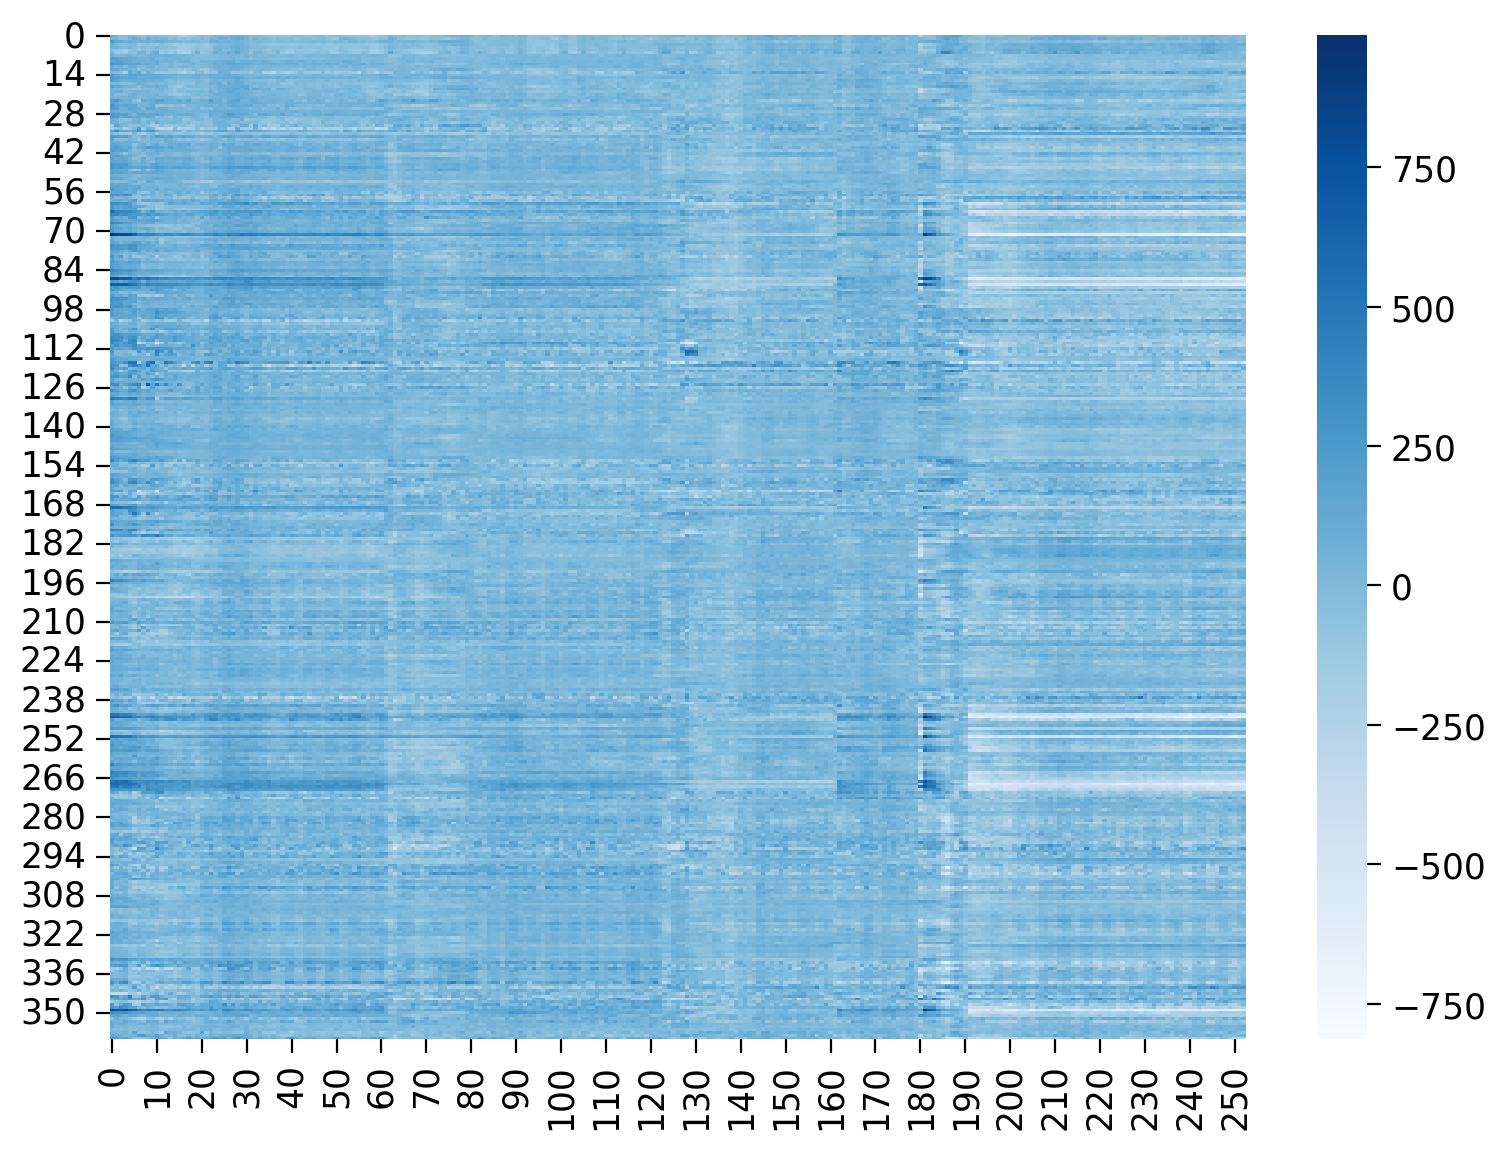

In [24]:
sns.heatmap(data, cmap="Blues")

In [25]:
140+28

168

As you can see the time series data contains 284 time points in 360 regions of interest (ROIs).



Now in order to understand how to model these data, we need to relate the time series to the experimental manipulation. This is described by the EV files. Let us load the EVs for this experiment.

In [26]:
evs = load_evs(subject=my_subj, experiment="GAMBLING", run=my_run)

In [27]:
# evs*0.72

For the motor task, this evs variable contains a list of 5 arrays corresponding to the 5 conditions.

Now let's use these evs to compare the average activity during the left foot ('lf') and right foot ('rf') conditions:

In [29]:
# we need a little function that averages all frames from any given condition
def average_frames(data, evs, experiment, cond):
  idx = EXPERIMENTS[experiment]['cond'].index(cond)
  return np.mean(np.concatenate([np.mean(data[:, evs[idx][i]], axis=1, keepdims=True) for i in range(len(evs[idx]))], axis=-1), axis=1)


lf_activity = average_frames(data, evs, my_exp, 'loss')
rf_activity = average_frames(data, evs, my_exp, 'win')
contrast = lf_activity - rf_activity  # difference between left and right hand movement

In [30]:
contrast.shape

(360,)

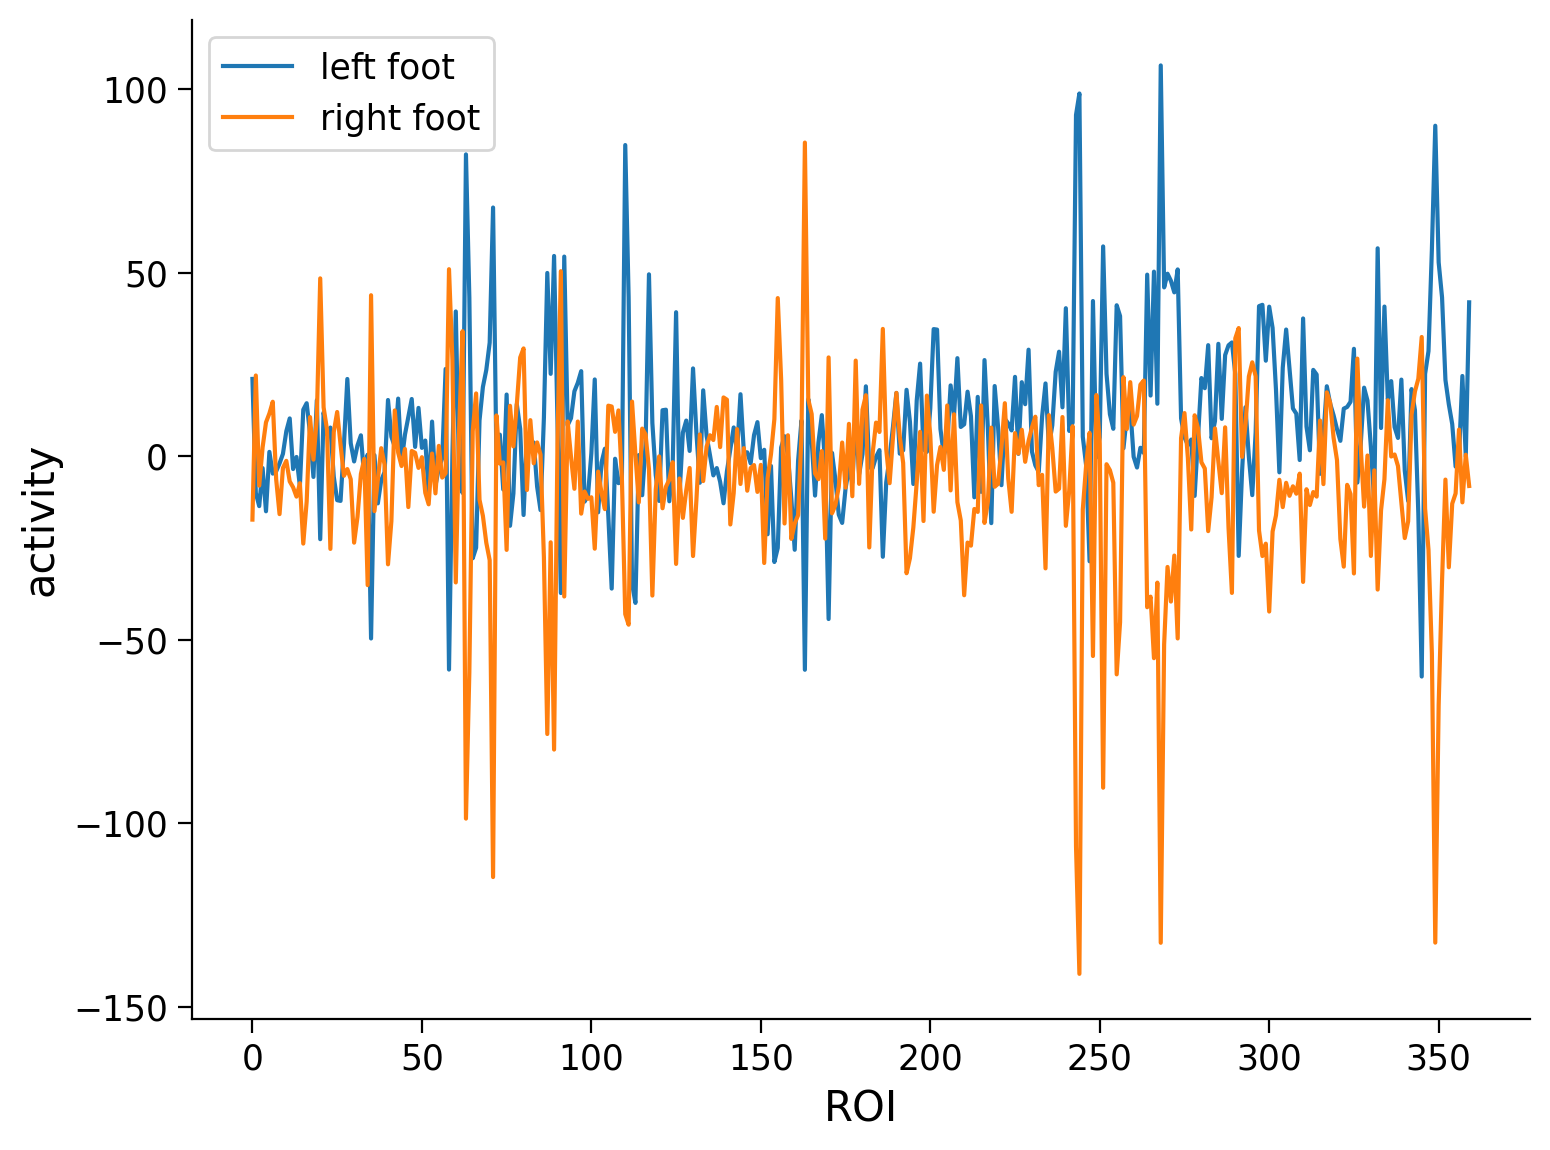

In [31]:
# Plot activity level in each ROI for both conditions
plt.plot(lf_activity,label='left foot')
plt.plot(rf_activity,label='right foot')
plt.xlabel('ROI')
plt.ylabel('activity')
plt.legend()
plt.show()

Now let's plot these activity vectors. We will also make use of the ROI names to find out which brain areas show highest activity in these conditions. But since there are so many areas, we will group them by network.

A powerful tool for organising and plotting this data is the combination of pandas and seaborn. Below is an example where we use pandas to create a table for the activity data and we use seaborn oto visualise it.





In [32]:
# prompt: in df show me all unique values of network

# Create a dataframe
df = pd.DataFrame(data={'region': region_info['name'],
                         'network': region_info['network'],
                         'hemi': region_info['hemi'],
                         'contrast': contrast,
                         'lf_activity': lf_activity,
                         'rf_activity': rf_activity})

# Print unique values of 'network'
print(df['network'].unique())


['Visual1' 'Visual2' 'Somatomotor' 'Cingulo-Oper' 'Language' 'Default'
 'Frontopariet' 'Auditory' 'Dorsal-atten' 'Posterior-Mu' 'Orbito-Affec'
 'Ventral-Mult']


In [33]:
df

,region,network,hemi,contrast,lf_activity,rf_activity
0,R_V1,Visual1,Right,38.333690,21.092810,-17.240880
1,R_MST,Visual2,Right,-32.026280,-9.997003,22.029277
2,R_V6,Visual2,Right,-5.573392,-13.563272,-7.989881
3,R_V2,Visual2,Right,-5.639760,-3.205630,2.434130
4,R_V3,Visual2,Right,-24.224880,-14.970970,9.253911
...,...,...,...,...,...,...
355,L_STSva,Posterior-Mu,Left,7.322666,-2.800550,-10.123216
356,L_TE1m,Frontopariet,Left,-7.176638,0.109211,7.285849
357,L_PI,Cingulo-Oper,Left,34.432694,21.893853,-12.538840
358,L_a32pr,Cingulo-Oper,Left,-0.516835,-0.080979,0.435856


In [34]:
# prompt: Using dataframe df: give me array of all indices with Cingulo-Oper as network

df[df["network"] == "Cingulo-Oper"].index.values # select rows with Cingulo-Oper in network column and extract the indices as a numpy array


array([  9,  36,  37,  42,  43,  44,  56,  57,  58,  59,  77,  83,  85,
        98, 104, 105, 107, 108, 112, 113, 146, 147, 166, 168, 177, 178,
       179, 189, 190, 204, 216, 217, 222, 223, 224, 236, 238, 239, 257,
       261, 263, 265, 278, 284, 285, 287, 288, 292, 293, 326, 327, 346,
       348, 357, 358, 359], dtype=int64)

In [35]:
nice_ind=df[df["network"] == "Orbito-Affec"].index.values
nice_ind

array([109, 111, 165, 289, 291, 345], dtype=int64)

In [36]:
# prompt: mean the values of data from indices in nice_ind

stonks=data[nice_ind, :].mean(axis=0)


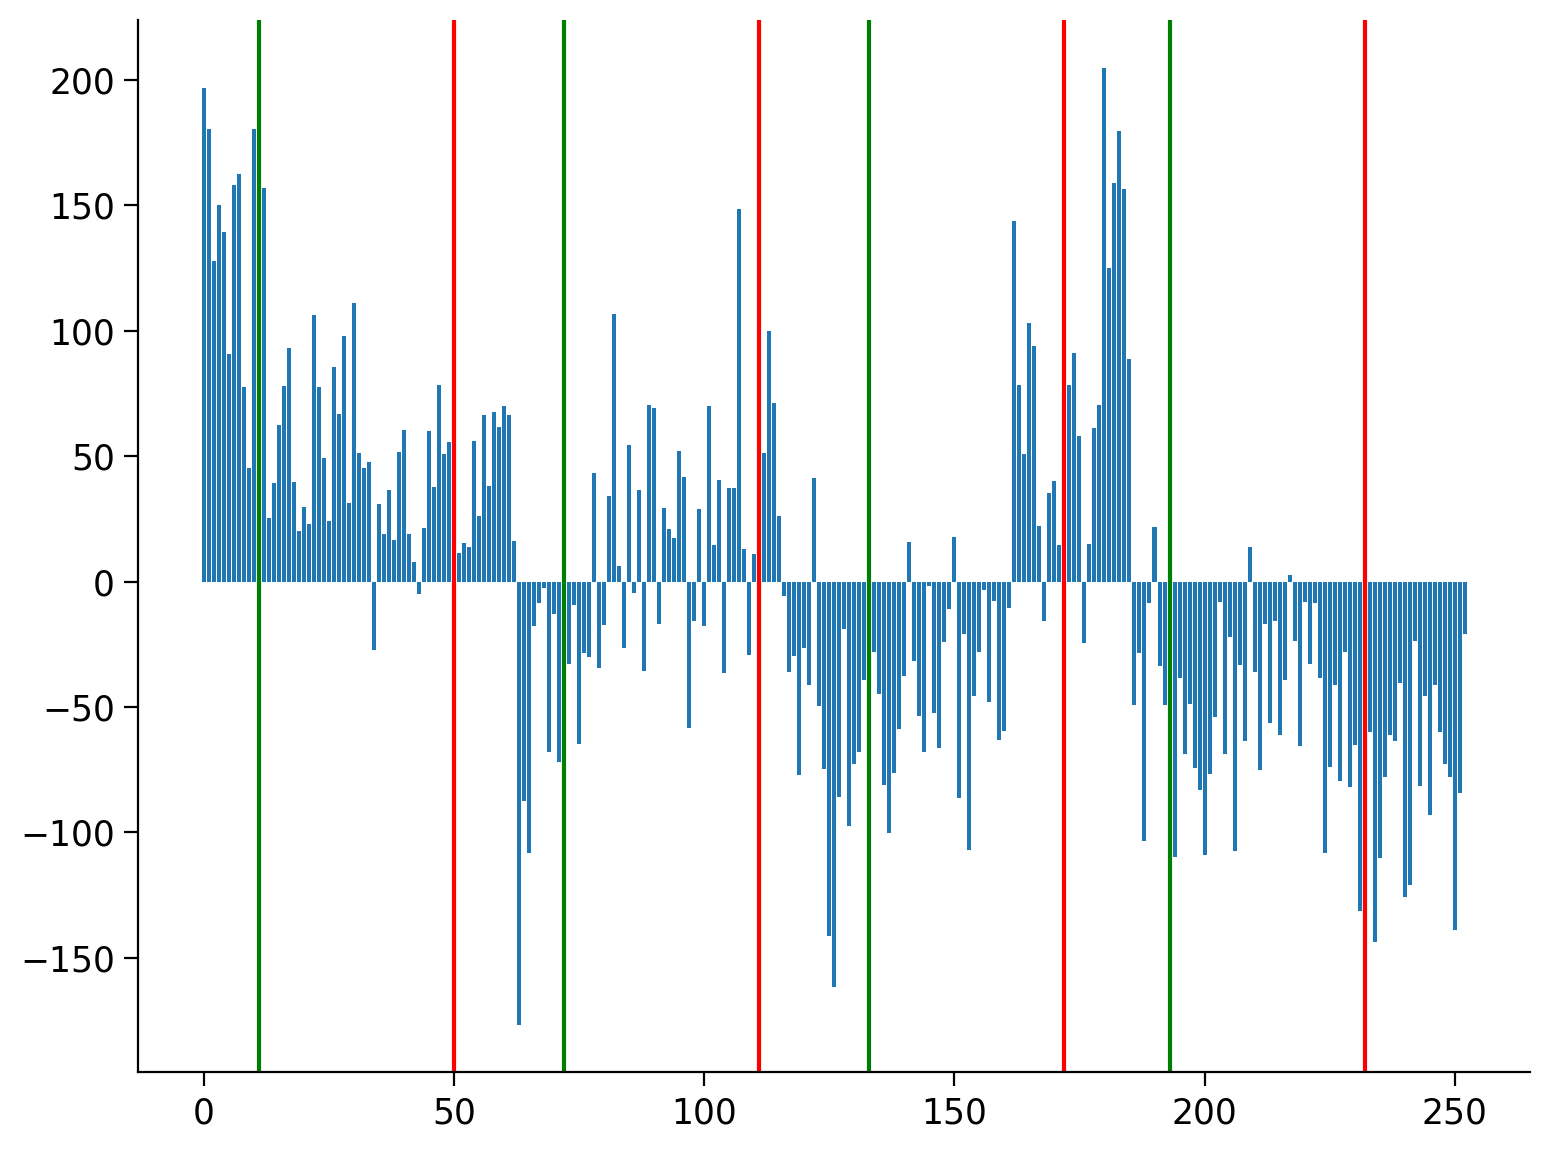

In [37]:
nice = [50,111,172,232]
wow = [11,72,133,193]
plt.bar(np.arange(data.shape[1]),stonks)
plt.axvline(nice[0],color='r')
plt.axvline(nice[1],color='r')
plt.axvline(nice[2],color='r')
plt.axvline(nice[3],color='r')
plt.axvline(wow[0],color='g')
plt.axvline(wow[1],color='g')
plt.axvline(wow[2],color='g')
plt.axvline(wow[3],color='g')

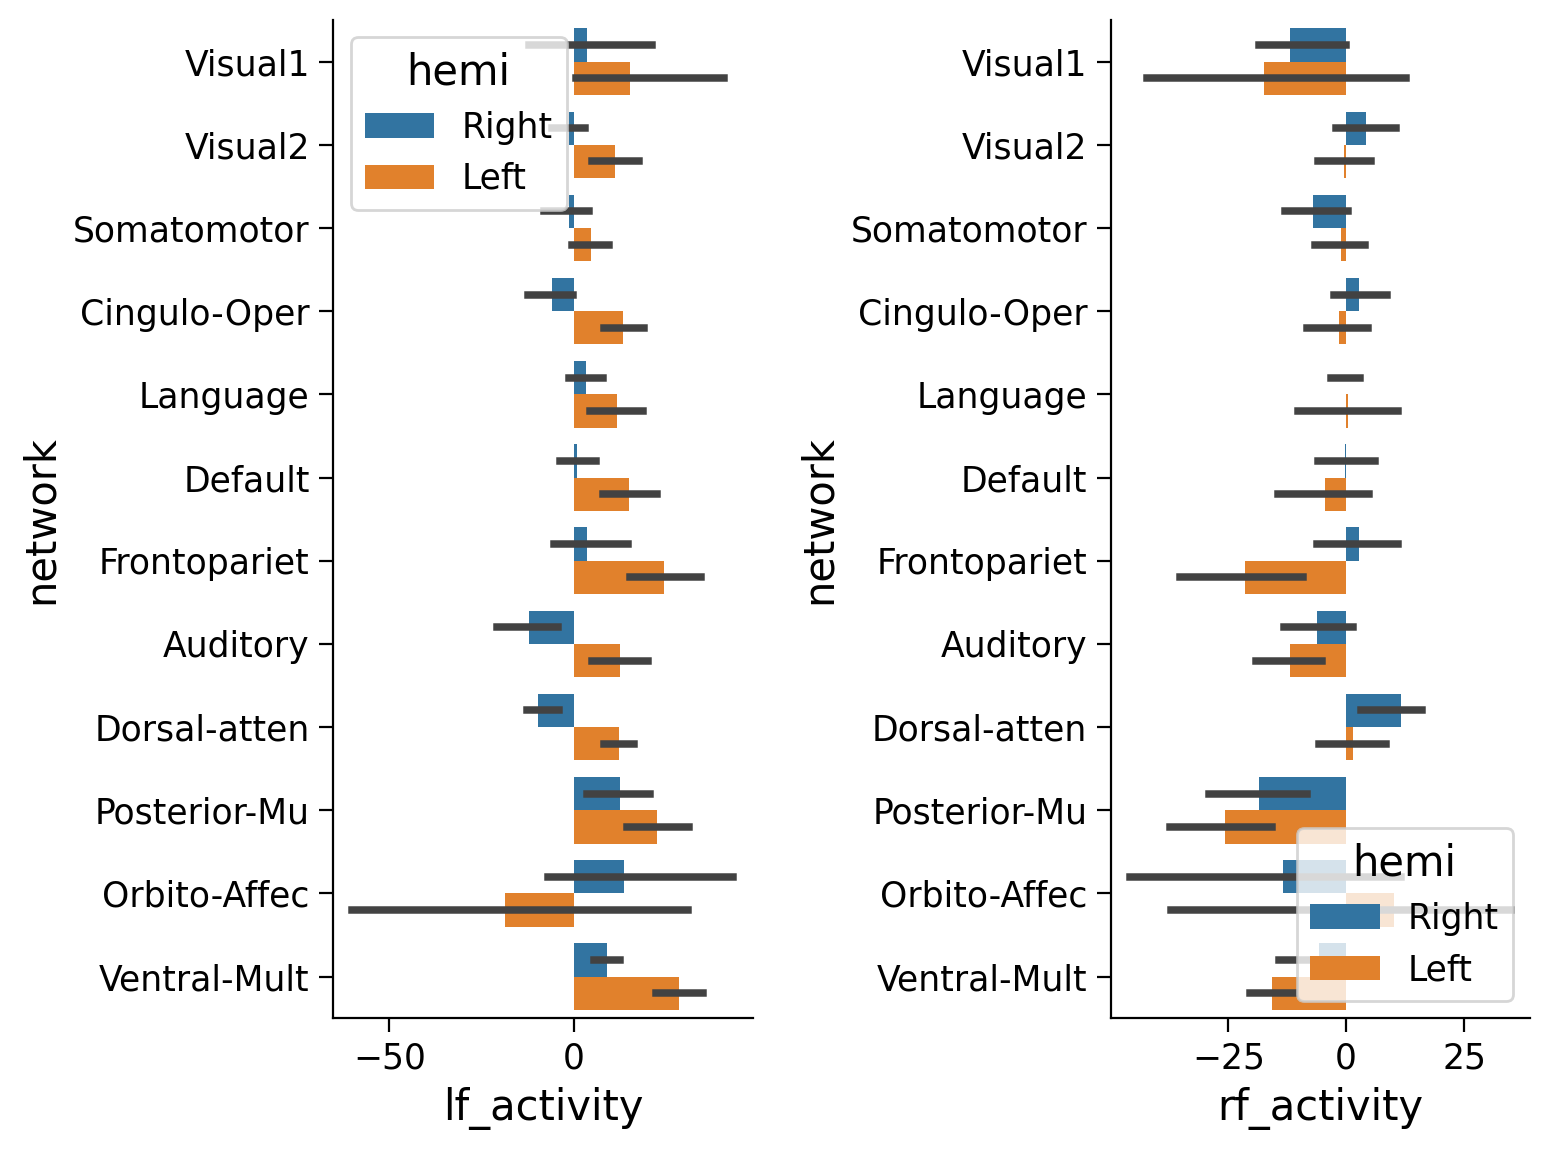

In [38]:
df = pd.DataFrame({'lf_activity' : lf_activity,
                   'rf_activity' : rf_activity,
                   'network' : region_info['network'],
                   'hemi' : region_info['hemi']})

fig, (ax1, ax2) = plt.subplots(1, 2)
sns.barplot(y='network', x='lf_activity', data=df, hue='hemi',ax=ax1)
sns.barplot(y='network', x='rf_activity', data=df, hue='hemi',ax=ax2)
plt.show()

You should be able to notice that for the somatosensory network, brain activity in the right hemi is higher for the left foot movement and vice versa for the left hemi and right foot. But this may be subtle at the single subject/session level (these are quick 3-4min scans).


Let us boost thee stats by averaging across all subjects and runs.

In [40]:
group_contrast = 0
for s in subjects:
  for r in [0, 1]:
    data = load_single_timeseries(subject=s, experiment=my_exp,
                                  run=r, remove_mean=True)
    evs = load_evs(subject=s, experiment=my_exp,run=r)

    lf_activity = average_frames(data, evs, my_exp, 'loss')
    rf_activity = average_frames(data, evs, my_exp, 'win')

    contrast = lf_activity - rf_activity
    group_contrast += contrast

group_contrast /= (len(subjects)*2)  # remember: 2 sessions per subject

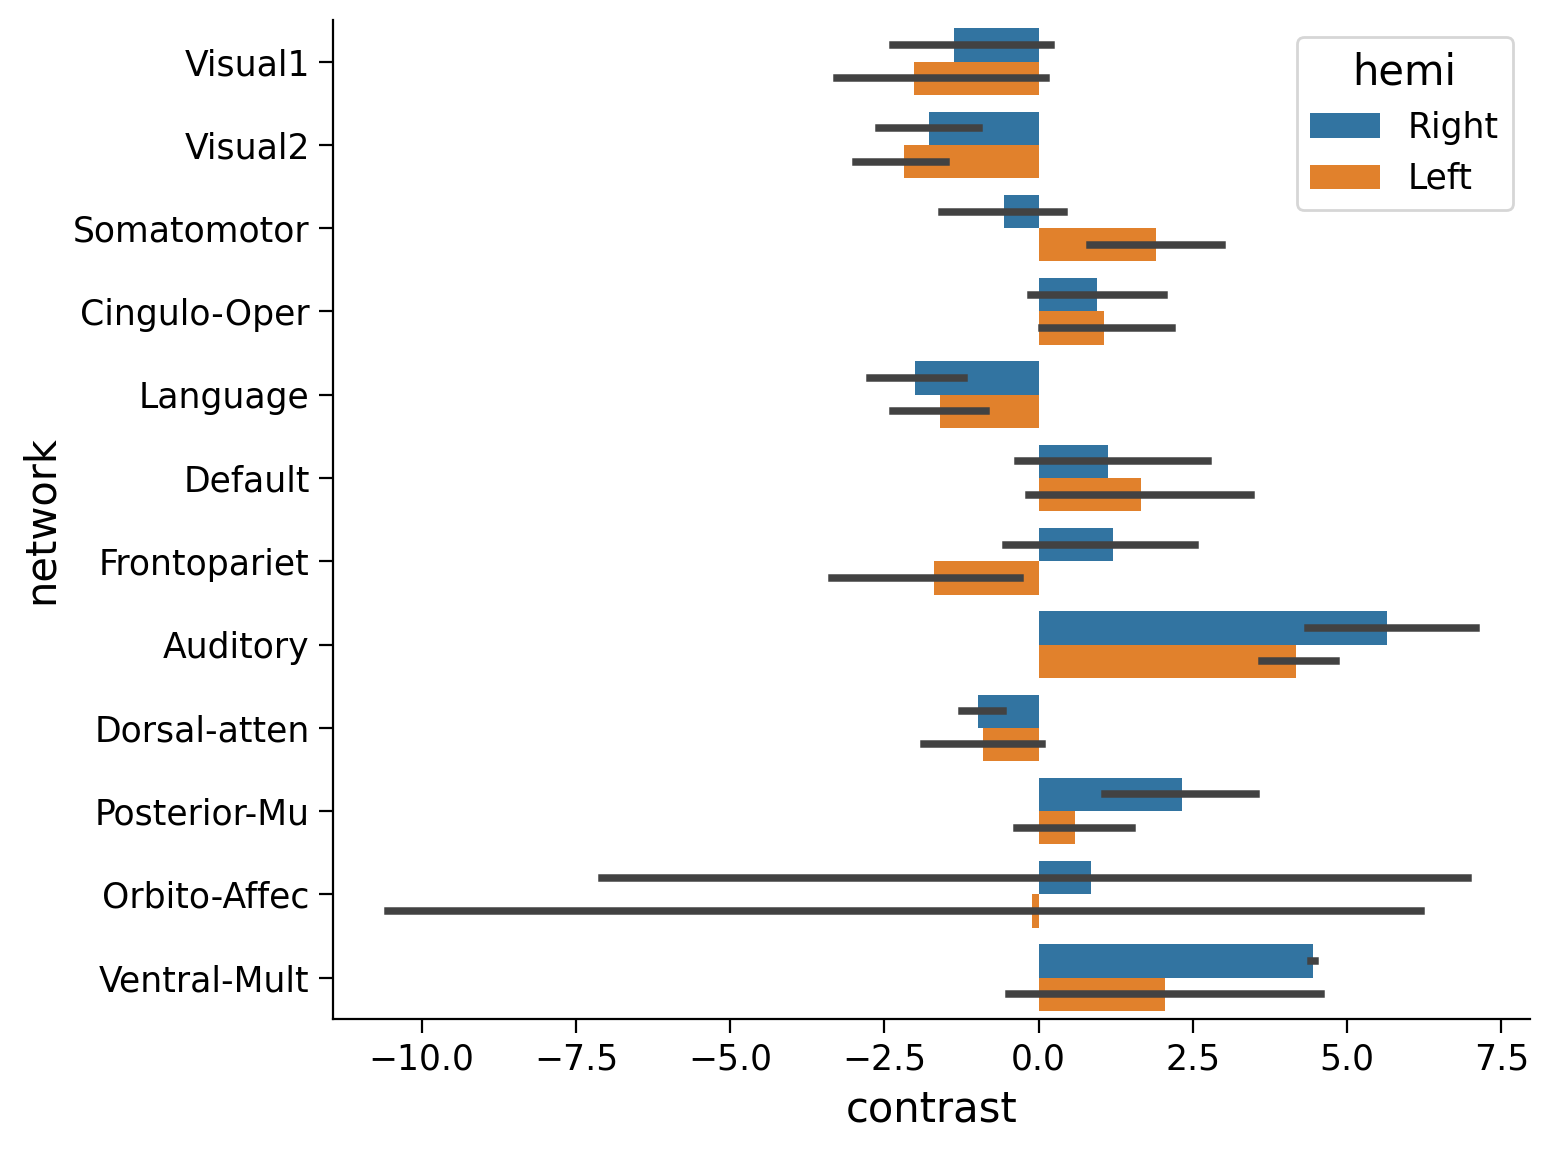

In [41]:
df = pd.DataFrame({'contrast' : group_contrast,
                   'network' : region_info['network'],
                   'hemi' : region_info['hemi']
                   })
# we will plot the left foot minus right foot contrast so we only need one plot
plt.figure()
sns.barplot(y='network', x='contrast', data=df, hue='hemi')
plt.show()

# Visualising the results on a brain

Finally, we will visualise these resuts on the cortical surface of an average brain.

In [42]:
# @title NMA provides an atlas. Run this cell to download it
import os, requests

# NMA provides an atlas
fname = f"{HCP_DIR}/atlas.npz"
url = "https://osf.io/j5kuc/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

with np.load(fname) as dobj:
  atlas = dict(**dobj)

In [43]:
# This uses the nilearn package
from nilearn import plotting, datasets

# Try both hemispheres (L->R and left->right)
fsaverage = datasets.fetch_surf_fsaverage()
surf_contrast = group_contrast[atlas["labels_L"]]
plotting.view_surf(fsaverage['infl_left'],
                   surf_contrast,
                   vmax=20)

In [44]:
group_contrast

array([-2.36308891e+00, -7.25856359e-01, -2.11381025e-01,  6.48972030e-01,
       -2.33007574e+00, -8.53221539e-01, -2.43630397e+00, -5.42348678e-03,
       -8.72493489e-01, -1.80343229e+00, -9.26513521e-02, -6.64294963e-02,
       -7.00444190e+00,  2.21698494e+00,  2.95322519e+00, -2.88601956e+00,
       -2.35919255e+00, -1.78825768e-01, -2.42858070e+00, -4.82047727e+00,
       -2.16074177e+00, -1.33437449e+00,  9.90387336e-01,  5.47086034e+00,
        9.98752902e-01,  3.40751258e+00, -1.13811175e+00,  1.86798068e+00,
        1.74190721e-01,  2.65522870e+00,  2.59690797e+00,  5.99068889e-01,
        4.42882994e+00,  1.13647914e-01,  2.04029105e-01, -2.32037520e-01,
       -2.38266571e+00, -1.51207966e+00,  3.85368896e-01, -3.92547938e-01,
        2.26879730e+00, -3.99234713e+00, -1.46166458e+00,  4.85563952e-02,
       -4.55296863e+00, -2.89428637e+00, -4.00842772e+00, -3.79221970e+00,
       -3.30209133e+00, -2.26353718e+00,  2.61260118e-02, -1.33266467e+00,
       -1.29991216e+00, -